This is the documentation for "M1M2: Deep-Learning-Based Real-Time Emotion Recognition from Neural Activity" paper by

Sumya Akter 1†, Rumman Ahmed Prodhan 1†, Tanmoy Sarkar Pias 2* , David Eisenberg 3*
and Jorge Fresneda Fernandez 1

1.   Martin Tuchman School of Management, New Jersey Institute of Technology, Newark, NJ 07102, USA 
2.   Department of Computer Science, Virginia Tech, Blacksburg, VA 24061, USA
3. Department of Information Systems, Ying Wu College of Computing, New Jersey Institute of Technology, Newark, NJ 07102, USA

\* Correspondence: tanmoysarkar@vt.edu (T.S.P.); de63@njit.edu (D.E.)

† These authors contributed equally to this work.

Published in MDPI Sensors: https://www.mdpi.com/1424-8220/22/21/8467

https://doi.org/10.3390/s22218467 









*Table 12. Accuracy with different train/test splits and their effect on time*

**CPU Configuration of the Colab Notebook for this experiment**

In [ ]:
! cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.164
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

**GPU Configuration of the Colab Notebook for this experiment**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 31 11:42:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Pyeeg has been installed**

In [ ]:
pip install git+https://github.com/forrestbao/pyeeg.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-wb6tpifs
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-wb6tpifs
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28131 sha256=7908a334f552c96f2266105d395a26f2a37d048470626e1b663d9f43baa922d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-sooqfu02/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg


**Here is the code for mounting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyeeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Imported the necessery library packages**

In [ ]:
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

**Location of dat file and location for where to save preprocessed npy files**

In [ ]:
path_to_dataset_2 = '/content/drive/Shareddrives/DEAP EEG/Dataset/physiological_recordings/data_preprocessed_python/' #Location of dat file of DEAP dataset
path_to_dataset = '/content/drive/Shareddrives/DEAP EEG/Preprocessed_data/' #where to save preprocessed npy files

**Intialize the channel array, band array, window_size, step_size and sample_rate and set the path of dataset of google drive.**

In [ ]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+

band = [4,8,12,16,25,45] #5 bands

window_size = 256 #Averaging band power of 2 sec// 
#window_size = [128, 256, ..., 8064]

step_size = 16 #Each 0.125 sec update once

sample_rate = 128 #Sampling rate of 128 Hz

subjectList=[] #taking an empty array to store subject numbers here
for i in range(1,33):
  if i<10:
     subjectList.append(f"{i:02d}") #to add extra '0' infront of 1 to 9 single digits
  else:
    subjectList.append(f"{i:2d}")


**Declaring FFT function. Taking the preprocessed dat file and converting it to a preprocessed npy file after FFT**

In [ ]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open(path_to_dataset_2+'s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save(path_to_dataset+'s' + sub, meta, allow_pickle=True, fix_imports=True) #saving each of the 32 files as npy after preprocessing

**Calling the FFT functions for each subjects**

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

##Dividing the Data into Training and Testing


#spliting and appending each npy into training, testing 








**80/20 Split**

Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520-3904=15616 (80%)
*   Testing :  19520/5=3904 (20%)

For training and testing
* The data training and label training both has 15616*32=499712 rows (80%)
* The data testing and label testing both has 3904*32=124928 rows (20%)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 5 == 0: # 19520/5=3904 (20%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else: # 19520-3904=15616 (80%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (499712, 70) (499712, 4)
testing dataset: (124928, 70) (124928, 4)


**75/25 Split**

Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520-4880=14640 (75%)
*   Testing : 19520/4=4880 (25%)

For training and testing
* The data training and label training both has 14640*32=468480 rows (75%)
* The data testing and label testing both has 4880*32=156160 rows (25%)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 4 == 0: # 19520/4=4880 (25%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            else: # 19520-4880=14640 (75%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

**Saving the data training, label training, data testing and label testing into google drive**


In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (384000, 70) (384000, 4)
testing dataset: (128000, 70) (128000, 4)


**50/50 Split**

Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520/2=9760 (50%)
*   Testing :  19520-9760=9760 (50%)

For training and testing
* The data training and label training both has 9760*32=312320 rows (50%)
* The data testing and label testing both has 9760*32=312320 rows (50%)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 2 == 0: # 19520/2=9760 (50%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])
            else: # 19520-9760=9760 (50%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (312320, 70) (312320, 4)
testing dataset: (312320, 70) (312320, 4)


**20/80 Split**

Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520/5=3904 (20%)
*   Testing :  19520-3904=15616 (80%)

For training and testing
* The data training and label training both has 3904*32=124928 rows (20%)
* The data testing and label testing both has 15616*32=499712 rows (80%)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 5 == 0: # 19520/5=3904 (20%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])
             
            else: # 19520-3904=15616 (80%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

**Saving the data training, label training, data testing and label testing into google drive**


In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (124928, 70) (124928, 4)
testing dataset: (499712, 70) (499712, 4)


**10/90 Split**

Dividing the 32 preprocessed npy file into data training, label training, data testing and label testing. Every npy file has 19520 rows and 4 columns which are valence, arousal, dominace and likings. Every npy file was divided by 4.

For each npy file

*   Training : 19520/10=1952 (10%)
*   Testing :  19520-1952=17568 (90%)

For training and testing
* The data training and label training both has 1952*32=62464 rows (10%)
* The data testing and label testing both has 17568*32=562176 rows (90%)

In [ ]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open(path_to_dataset + 's' + subjects + '.npy', 'rb') as file: 
        sub = np.load(file) # loading npy file
        for i in range (0,sub.shape[0]): # running loop over 19520 rows
            if i % 10 == 0: # 19520/10=1952 (10%)
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])
             
            else: # 19520-1952=17568 (90%)
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])

In [ ]:
# restore np.load for future normal usage
np.load = np_load_old

In [ ]:
np.save(path_to_dataset + 'data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(path_to_dataset + 'data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(path_to_dataset + 'label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (62464, 70) (62464, 4)
testing dataset: (562176, 70) (562176, 4)


**Here all the training file have been loaded .The data have been put in variable X and label values have been put in Y.Then the X has been Normalized and then valence label values have been loaded in Z. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [0]])

Valence_Train = np.ravel(Y[:, [0]])
Arousal_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

In [ ]:
Arousal_Train = Arousal_Train.reshape((468480, 1))
Domain_Train = Domain_Train.reshape((468480, 1))
Like_Train = Like_Train.reshape((468480, 1))

train = np.hstack([X, Arousal_Train, Domain_Train, Like_Train])
train.shape

(468480, 73)

In [ ]:
X_old = X
X = train

**All the training label values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**


In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(Z)):
  if Z[i] >= 1 and Z[i]<=4.99:
    Z [i] = 0
    count_0 = count_0 + 1
  else:
    Z [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

203496 264984


**Necessery libraries are imported**


In [ ]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
import warnings
warnings.filterwarnings('ignore')

**Here all the training label values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.** 

1.  1-4.99 ----> catagory(0)
2.  5-8.99 ----> catagory(1)

In [ ]:
y_train = to_categorical(Z)
y_train[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Values of X are put in x_train as numpy array format**

In [ ]:
x_train = np.array(X[:])

**Here all the testing file have been loaded .The data have been put in variable M and label values have been put in N.Then the M has been Normalized and then valence label values have been loaded in L. And then all the '9' values are converted into '8.99' of valence label.**

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [0]])


Valence_Test = np.ravel(N[:, [0]])
Arousal_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99

**All the testing labels values are divided into two segments. One segment contains values from 1 - 4.9 and another contains rest of the range's values. This approch is maintained for valence, arousal, dominance, likings binary classifications but not for other class classification.**

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(L)):
  if L[i] >= 1 and L[i]<=4.99:
    L [i] = 0
    count_0 = count_0 + 1
  else:
    L [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

67832 88328


In [ ]:
M.shape

(156160, 70)

In [ ]:
Arousal_Test = Arousal_Test.reshape((156160, 1))
Domain_Test = Domain_Test.reshape((156160, 1))
Like_Test = Like_Test.reshape((156160, 1))

test = np.hstack([M, Arousal_Test, Domain_Test, Like_Test])
test.shape

(156160, 73)

**Vules of M are assigned in x_test in numpy array format**

In [ ]:
x_test = np.array(test[:])
x_test

array([[0.07006464, 0.10438554, 0.06634758, ..., 7.6       , 6.9       ,
        7.83      ],
       [0.07695878, 0.10655808, 0.05897592, ..., 7.6       , 6.9       ,
        7.83      ],
       [0.07546743, 0.08606705, 0.07999725, ..., 7.6       , 6.9       ,
        7.83      ],
       ...,
       [0.1897225 , 0.11085076, 0.04970787, ..., 4.03      , 9.        ,
        1.88      ],
       [0.17817637, 0.08834064, 0.05389381, ..., 4.03      , 9.        ,
        1.88      ],
       [0.14543648, 0.08345535, 0.04799341, ..., 4.03      , 9.        ,
        1.88      ]])

**Here all the tessting labels values are categorised. For binary classification and it is catagorised into two catagory. value range 1 - 4.99 have been assigned in catagory '0' and rest of the value are assigned in catagory '1'.**

* 1-4.99 ----> catagory(0)
* 5-8.99 ----> catagory(1)

In [ ]:
from tensorflow.keras.utils import to_categorical 
y_test = to_categorical(L)

**Fit the train and test data with StandarScaler**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

In [ ]:
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

**Two dimensional data are converted into three dimension by adding one constant dimension’s value '1'. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(468480, 73, 1) (156160, 73, 1) (468480, 2) (156160, 2)


In [ ]:
print(x_train.shape,  y_train.shape)

(468480, 73, 1) (468480, 2)


**Here define the batch_size, number of class used in model architecture ,how many epoch will be run with the model and also define the input_shape. This is for CNN, LSTM and Bi-LSTM only**

In [ ]:
batch_size = 256
num_classes = 2
epochs = 100

input_shape=(x_train.shape[1], 1)

**import another library packages**

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model

# Deep Learning Algorithms

##CNN Model with Residual Connection

**M2**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 73, 16)       112         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 73, 16)      64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 36, 16)       0           ['batch_normalization[0][0]']

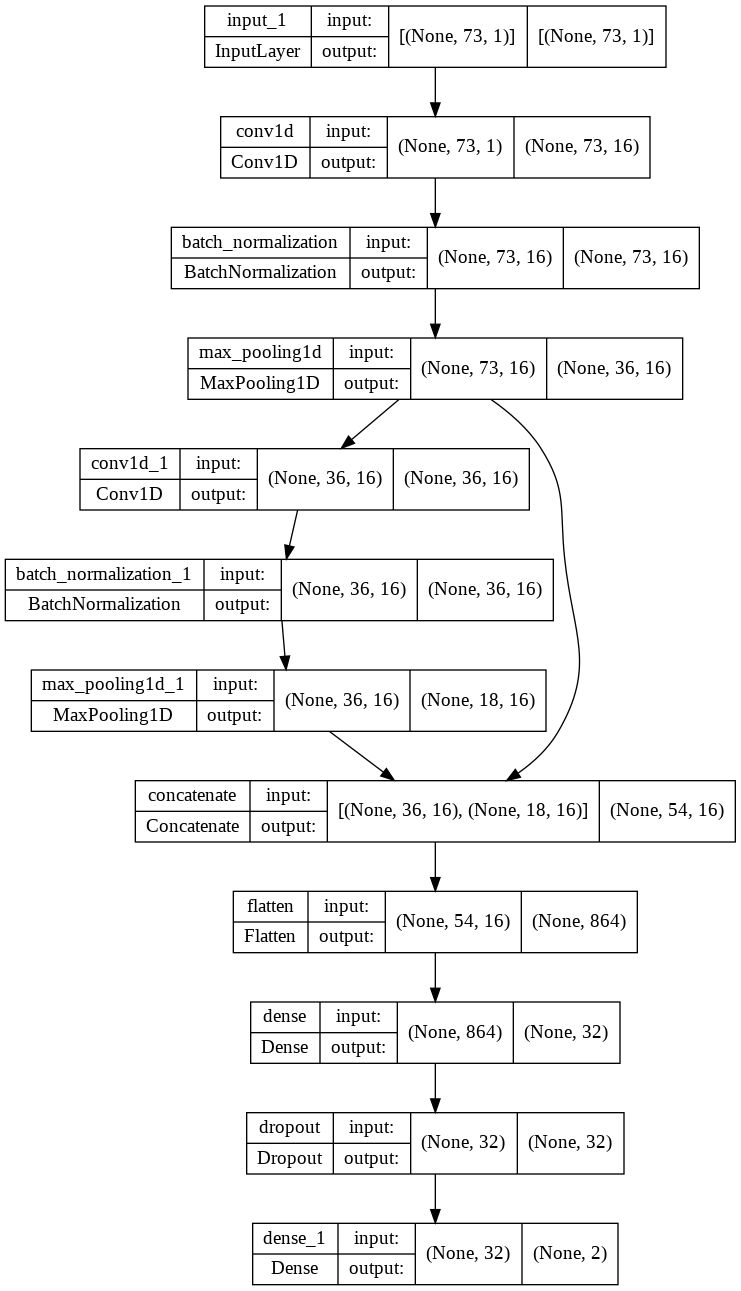

In [ ]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model


intput_shape=(x_train.shape[1], 1) #x_train.shape[1]

input_layer = Input(intput_shape)

conv1 = Conv1D(16, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(16,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2) 
pool2 = MaxPooling1D(pool_size=(2)) (bn2)


connect1 = concatenate([pool1, pool2], axis=1)


flat = Flatten() (connect1)




dense3 = Dense(32, activation='relu') (flat)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compiling the model**

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam',
              metrics=['accuracy'])

**train 80% test 20%**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/80_20_Train_Test/2nd/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/80_20_Train_Test/2nd/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


In [ ]:
%%time
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4998/4998 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.8604
Epoch 1: accuracy improved from -inf to 0.86036, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/80_20_Train_Test/2nd/weights-improvement-01-0.8604.hdf5
4998/4998 [==============================] - 53s 8ms/step - loss: 0.3041 - accuracy: 0.8604 - val_loss: 0.1976 - val_accuracy: 0.9111
Epoch 2/100
4997/4998 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9126
Epoch 2: accuracy improved from 0.86036 to 0.91263, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/80_20_Train_Test/2nd/weights-improvement-02-0.9126.hdf5
4998/4998 [==============================] - 37s 7ms/step - loss: 0.1927 - accuracy: 0.9126 - val_loss: 0.1367 - val_accuracy: 0.9399
Epoch 3/100
4997/4998 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9311
Epoch 3: accuracy improved fro

In [ ]:
%%time
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3904/3904 [==============================] - 15s 4ms/step - loss: 0.0225 - accuracy: 0.9903
Test loss: 0.022504897788167
Test accuracy: 0.9902504086494446
CPU times: user 15.3 s, sys: 2.52 s, total: 17.8 s
Wall time: 15.3 s


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/80_20_Train_Test/2nd/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**train 75% test 25%**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/75_25_Train_Test/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/75_25_Train_Test/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


In [ ]:
%%time
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
4683/4685 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8619
Epoch 1: accuracy improved from -inf to 0.86194, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/75_25_Train_Test/weights-improvement-01-0.8619.hdf5
4685/4685 [==============================] - 42s 6ms/step - loss: 0.3008 - accuracy: 0.8619 - val_loss: 0.1888 - val_accuracy: 0.9174
Epoch 2/100
4680/4685 [============================>.] - ETA: 0s - loss: 0.1863 - accuracy: 0.9156
Epoch 2: accuracy improved from 0.86194 to 0.91558, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/75_25_Train_Test/weights-improvement-02-0.9156.hdf5
4685/4685 [==============================] - 25s 5ms/step - loss: 0.1863 - accuracy: 0.9156 - val_loss: 0.1294 - val_accuracy: 0.9451
Epoch 3/100
4685/4685 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9320
Epoch 3: accuracy improved from 0.9155

In [ ]:
%%time
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 13s 3ms/step - loss: 0.0200 - accuracy: 0.9926
Test loss: 0.019990870729088783
Test accuracy: 0.9926357865333557
CPU times: user 14.2 s, sys: 1.66 s, total: 15.9 s
Wall time: 20.8 s


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/75_25_Train_Test/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**train 50% test 50%**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/50_50_Train_Test/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/50_50_Train_Test/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


In [ ]:
%%time
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
3124/3124 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8496
Epoch 1: accuracy improved from -inf to 0.84961, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/50_50_Train_Test/weights-improvement-01-0.8496.hdf5
3124/3124 [==============================] - 48s 11ms/step - loss: 0.3266 - accuracy: 0.8496 - val_loss: 0.2230 - val_accuracy: 0.8981
Epoch 2/100
3121/3124 [============================>.] - ETA: 0s - loss: 0.2204 - accuracy: 0.8971
Epoch 2: accuracy improved from 0.84961 to 0.89712, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/50_50_Train_Test/weights-improvement-02-0.8971.hdf5
3124/3124 [==============================] - 29s 9ms/step - loss: 0.2204 - accuracy: 0.8971 - val_loss: 0.1572 - val_accuracy: 0.9304
Epoch 3/100
3122/3124 [============================>.] - ETA: 0s - loss: 0.1815 - accuracy: 0.9144
Epoch 3: accuracy improved from 0.897

In [ ]:
%%time
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

9760/9760 [==============================] - 37s 4ms/step - loss: 0.0232 - accuracy: 0.9920
Test loss: 0.023218221962451935
Test accuracy: 0.9919825792312622
CPU times: user 38.2 s, sys: 6.05 s, total: 44.2 s
Wall time: 37.6 s


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/50_50_Train_Test/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**train 20% test 80%**

In [ ]:
%%time
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
1249/1250 [============================>.] - ETA: 0s - loss: 0.4011 - accuracy: 0.8130
Epoch 1: accuracy improved from -inf to 0.81297, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/20_80_Train_Test/weights-improvement-01-0.8130.hdf5
1250/1250 [==============================] - 28s 22ms/step - loss: 0.4011 - accuracy: 0.8130 - val_loss: 0.3120 - val_accuracy: 0.8561
Epoch 2/100
1247/1250 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8611
Epoch 2: accuracy improved from 0.81297 to 0.86112, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/20_80_Train_Test/weights-improvement-02-0.8611.hdf5
1250/1250 [==============================] - 27s 21ms/step - loss: 0.3041 - accuracy: 0.8611 - val_loss: 0.2499 - val_accuracy: 0.8893
Epoch 3/100
1246/1250 [============================>.] - ETA: 0s - loss: 0.2592 - accuracy: 0.8819
Epoch 3: accuracy improved from 0.86

In [ ]:
%%time
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

15616/15616 [==============================] - 44s 3ms/step - loss: 0.0439 - accuracy: 0.9835
Test loss: 0.04386339709162712
Test accuracy: 0.9835125207901001
CPU times: user 47 s, sys: 4.71 s, total: 51.7 s
Wall time: 44 s


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/20_80_Train_Test/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)

**train 10% test 90%**

In [ ]:
# check points and early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping

model_name = ""
filepath="/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/10_90_Train_Test/"  + model_name + "weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/10_90_Train_Test/weights-improvement-{epoch:02d}-{accuracy:.4f}.hdf5


In [ ]:
%%time
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.7975
Epoch 1: accuracy improved from -inf to 0.79745, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/10_90_Train_Test/weights-improvement-01-0.7975.hdf5
625/625 [==============================] - 27s 41ms/step - loss: 0.4317 - accuracy: 0.7975 - val_loss: 0.3581 - val_accuracy: 0.8384
Epoch 2/100
623/625 [============================>.] - ETA: 0s - loss: 0.3516 - accuracy: 0.8390
Epoch 2: accuracy improved from 0.79745 to 0.83896, saving model to /content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/10_90_Train_Test/weights-improvement-02-0.8390.hdf5
625/625 [==============================] - 26s 41ms/step - loss: 0.3516 - accuracy: 0.8390 - val_loss: 0.3135 - val_accuracy: 0.8600
Epoch 3/100
619/625 [============================>.] - ETA: 0s - loss: 0.3147 - accuracy: 0.8560
Epoch 3: accuracy improved from 0.83896 to 0.8

In [ ]:
%%time
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

17568/17568 [==============================] - 67s 4ms/step - loss: 0.0779 - accuracy: 0.9685
Test loss: 0.07789862900972366
Test accuracy: 0.9684671759605408
CPU times: user 1min 8s, sys: 11.4 s, total: 1min 19s
Wall time: 1min 22s


In [ ]:
with open('/content/drive/Shareddrives/DEAP EEG/Models Saved/Valence/Train_Test_Split_MDPI/10_90_Train_Test/history', 'wb') as file_pi:
        pickle.dump(H.history, file_pi)